# Notebook Prétraitement Prédiction

L'objectif de ce notebook est de construire un modèle de scoring pouvant renvoyer une prédiction sur la probabilité de faillite d'un client donné.

* [Partie 1 : import des packages et déclarations des fonctions, constantes et variables](#partie1)
    * [Import des packages](#section_1_1)
    * [Décorateur de mesure du temps d'éxecution](#section_1_2)
    * [Fonctions liées au scoring](#section_1_3)
    * [Fonction de report des statistiques principales](#section_1_4)
    * [Fonctions liées à la jointure des fichiers .csv](#section_1_5)
    * [Fonctions liées à la préparation des datasets pour la modélisation](#section_1_6)
    * [Déclaration des constantes / variables principales](#section_1_7)
    * [Déclaration des espaces de recherche](#section_1_8)

* [Partie 2 : Pré-traitement du dataset](#partie2)
    * [Extraction des fichiers de l'archive](#section_2_1)
    * [Pré-traitement initial : fusion des .csv / conservation des variables principales](#section_2_2)
    * [Evaluation de la quantité de valeurs manquantes](#section_2_3)
    * [Imputation des valeurs manquantes](#section_2_4)
    * [Feature Engineering](#section_2_5)
    * [Visualisations après prétraitement](#section_2_6)
    * [Exportation du jeu de données total après prétraitement](#section_2_7)

* [Partie 3 : Modélisation](#partie3)
    * [Initialisation de MLFlow](#section_3_1)
    * [Préparation des datasets d'entraînement / test / score](#section_3_2)
    * [Modèle Baseline : Dummy Classifier](#section_3_3)
    * [Régression Logistique](#section_3_4)
    * [XGBoost](#section_3_5)
    * [LightGBM](#section_3_6)
    * [Évaluation de la courbe ROC (AUC)](#section_3_7)
    * [Fine Tuning du modèle sélectionné](#section_3_8)
    * [Évaluation de la courbe ROC (AUC) du modèle Fine Tuned](#section_3_9)
    * [Déclaration du modèle final](#section_3_10)
    * [Création des SHAP Explainer / Values pour l'interprétabilité locale et globale](#section_3_11)
    * [Sérialisation des modèles et des SHAP Explainer / Values](#section_3_12)
    * [Chargement des datasets sauvegardés précédemment et définition des datasets évalués](#section_3_13)

* [Partie 4 : Analyse du Data Drift (evidently)](#partie4)
    * [Train vs Test](#section_4_1)
    * [Train vs Score](#section_4_2)
    * [Train vs App](#section_4_3)

# Partie 1 : import des packages et déclarations des fonctions, constantes et variables<a class="anchor" id="partie1"></a>

### Import des packages<a class="anchor" id="section_1_1"></a>

In [1]:
import os, sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [2]:
import gc
import time
from contextlib import contextmanager
import pickle
from zipfile import ZipFile

import numpy as np   
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, auc, RocCurveDisplay, make_scorer, fbeta_score, precision_recall_curve, roc_auc_score 
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
from evidently.metrics import *
from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset
from evidently.tests import *

import mlflow

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from skopt import BayesSearchCV

import shap
shap.initjs()

### Décorateur de mesure du temps d'éxecution<a class="anchor" id="section_1_2"></a>

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    total = time.time() - t0
    print("{} - réalisé en {:.0f}s".format(title, total))
    mlflow.log_metric(title, total)

### Fonctions liées au scoring<a class="anchor" id="section_1_3"></a>

In [4]:
def binarize(y, t):
    out = []
    for pred in (y):
        if (pred > t):
            out.append(0)
        else:
            out.append(1)
    return np.array(out)

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def select_best_threshold(true_y, pred_y):
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [fbeta_score(true_y, to_labels(pred_y, t), beta=2) for t in thresholds]
    # return best threshold
    return thresholds[np.argmax(scores)]

def business_cost(true_y, pred_y):
    score = 0
    mismatch_fp = 1
    mismatch_fn = mismatch_fp * 10
    
    true_y = true_y.tolist()
    pred_y = to_labels(pred_y, select_best_threshold(true_y, pred_y))
    
    for i in range(len(true_y)):
        if (true_y[i] != pred_y[i]):
            if (true_y[i] == 1):
                score += mismatch_fp
            else:
                score += mismatch_fn

    return score

def fbeta_cost(true_y, pred_y):
    true_y = true_y.tolist()
    pred_y = to_labels(pred_y, select_best_threshold(true_y, pred_y))
    return fbeta_score(true_y, pred_y, beta=2, average='binary', pos_label=0)

business_loss = make_scorer(business_cost, greater_is_better=False, needs_proba=True)
fbeta_loss = make_scorer(fbeta_cost, greater_is_better=True, needs_proba=True)

### Fonction de report des statistiques principales<a class="anchor" id="section_1_4"></a>

In [5]:
def generate_stats(model, model_name, X_train, X_test, y_train, y_test):
    # Recherche du meilleur seuil de décision sur le jeu d'entraînement
    with timer("Prédiction du " + model_name + " model"):
        y_proba = model.predict_proba(X_train)
    probs = y_proba[:, 1]
    thresholds = np.arange(0, 1, 0.001)
    scores = [fbeta_score(y_train, to_labels(probs, t), beta=2) for t in thresholds]
    ix = np.argmax(scores)

    # Exploitation du seuil et évaluation sur jeu de test
    y_proba = model.predict_proba(X_test)
    probs = y_proba[:, 1]
    y_pred = to_labels(probs, thresholds[ix])
    
    business_cost_model = business_cost(y_test, y_pred)
    model_report = classification_report(y_test, y_pred, output_dict=True)
    
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    
    # Enregistrement dans MLFlow

    mlflow.log_metric('ROC AUC', roc_auc_score(y_test, y_pred))
    mlflow.log_metric('Precision Recall Curve AUC', auc(recall, precision))
    
    mlflow.log_metric('Best threshold', thresholds[ix])
    mlflow.log_metric('Best FBeta Score', scores[ix])
    mlflow.log_metric('Business Scoring value', business_cost_model)

    mlflow.log_metric('Negative targets Precision', str(round(model_report['0']['precision'],2)))
    mlflow.log_metric('Negative targets Recall', str(round(model_report['0']['recall'],2)))
    mlflow.log_metric('Negative targets F1-Score', str(round(model_report['0']['f1-score'],2)))
    mlflow.log_metric('Positive targets Precision', str(round(model_report['1']['precision'],2)))
    mlflow.log_metric('Positive targets Recall', str(round(model_report['1']['recall'],2)))
    mlflow.log_metric('Positive targets F1-Score', str(round(model_report['1']['f1-score'],2)))

    mlflow.log_metric('Accuracy', str(round(model_report['accuracy'],2)))

    mlflow.log_metric('Macro AVG Precision', str(round(model_report['macro avg']['precision'],2)))
    mlflow.log_metric('Macro AVG Recall', str(round(model_report['macro avg']['recall'],2)))
    mlflow.log_metric('Macro AVG F1-Score', str(round(model_report['macro avg']['f1-score'],2)))
    mlflow.log_metric('Weighted AVG Precision', str(round(model_report['weighted avg']['precision'],2)))
    mlflow.log_metric('Weighted AVG Recall', str(round(model_report['weighted avg']['recall'],2)))
    mlflow.log_metric('Weighted AVG F1-Score', str(round(model_report['weighted avg']['f1-score'],2)))
    
    # Actuellement davantage un contournement, pas très production friendly mais fonctionnel
    if (model_name not in ["lightgbm", "dummy"]): # Modèles posant problème avec SHAP
        if (model_name == 'logistic_regression'):
            shap_explainer = shap.Explainer(model, X_test, algorithm = 'auto', n_jobs = -1)
            shap_values = shap_explainer(X_test)
        else:
            shap_explainer = shap.TreeExplainer(model, X_test, algorithm = 'auto', n_jobs = -1)
            shap_values = shap_explainer(X_test)

        plt.clf()
        shap.plots.beeswarm(shap_values, show=False)
        plt.savefig(model_name + '_shap_beeswarm.png', bbox_inches='tight', dpi=300)
        beeswarm, ax = plt.subplots()
        ax.imshow(plt.imread(model_name + '_shap_beeswarm.png'))
        mlflow.log_figure(beeswarm, model_name + '_shap_beeswarm.png')

        plt.clf()
        shap.plots.bar(shap_values, show=False)
        plt.savefig(model_name + '_shap_bar.png', bbox_inches='tight', dpi=300)
        bar, ax = plt.subplots()
        ax.imshow(plt.imread(model_name + '_shap_bar.png'))
        mlflow.log_figure(bar, model_name + '_shap_bar.png')

### Fonctions liées à la jointure des fichiers .csv<a class="anchor" id="section_1_5"></a>

In [6]:
# Exploitation de pd.get_dummies pour le one-hot encoding de variables catégorielles
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess de application_train.csv et application_test.csv
def application_train_test(base_path, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(base_path + 'application_train.csv')
    test_df = pd.read_csv(base_path + 'application_test.csv')
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], ignore_index=True).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(base_path, nan_as_category = True):
    bureau = pd.read_csv(base_path + 'bureau.csv')
    bb = pd.read_csv(base_path + 'bureau_balance.csv')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(base_path, nan_as_category = True):
    prev = pd.read_csv(base_path + 'previous_application.csv')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(base_path, nan_as_category = True):
    pos = pd.read_csv(base_path + 'POS_CASH_balance.csv')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(base_path, nan_as_category = True):
    ins = pd.read_csv(base_path + 'installments_payments.csv')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(base_path, nan_as_category = True):
    cc = pd.read_csv(base_path + 'credit_card_balance.csv')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

def big_merge(base_path):
    """ Je vais fusionner toutes les colonnes présentes """
    df = application_train_test(base_path)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(base_path)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(base_path)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(base_path)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(base_path)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(base_path)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
    return df
    
def big_drop(input_df, features):
    """ Je renvoie le dataframe d'entrée avec les colonnes indiquées par features """
    output_df = input_df[features]
    return output_df.reset_index()

### Fonctions liées à la préparation des datasets pour la modélisation<a class="anchor" id="section_1_6"></a>

In [7]:
def export_datasets(train_df, test_df, score_df):
    train_df.to_csv(OUTPUT_DATASETS_PATH + 'train_data.csv', header=True, index=False)
    test_df.to_csv(OUTPUT_DATASETS_PATH + 'test_data.csv', header=True, index=False)
    score_df.to_csv(OUTPUT_DATASETS_PATH + 'score_data.csv', header=True, index=False)

def dataset_splitter(input_df, splitter, features, target):
    for train_index, test_index in splitter.split(input_df[features], input_df[target]):
        dataset_1 = input_df.loc[test_index]
        dataset_2 = input_df.loc[train_index]
    return dataset_1, dataset_2

def prepare_datasets(input_df):    
    # Préparation des variables principales
    # Features
    features = [f for f in input_df.columns if f not in ['level_0', 'TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    # Cible
    target = 'TARGET'
    # Méthodes de découpe du dataset initial en jeux d'entraînement, test et score
    score_spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=111)
    train_spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    # Création de train_df, test_df, score_df
    score_df, main_df = dataset_splitter(input_df, score_spliter, features, target)
    # Reset des index de main_df
    main_df.reset_index(inplace=True)
    test_df, train_df = dataset_splitter(main_df, train_spliter, features, target)
    # Elimination des colonnes indésirables, reset final des index
    train_df.drop(columns=['level_0'], axis=1, inplace=True)
    test_df.drop(columns=['level_0'], axis=1, inplace=True)
    train_df.reset_index(inplace=True)
    test_df.reset_index(inplace=True)
    score_df.reset_index(inplace=True)
    # Export des datasets pour emploi ultérieur
    export_datasets(train_df, test_df, score_df)
    # Elimination des dataframes initiaux
    del score_df
    del input_df
    gc.collect()
    # Création des sorties
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[target]
    y_test = test_df[target]
    # Sortie
    return X_train, X_test, y_train, y_test

### Déclaration des constantes / variables principales<a class="anchor" id="section_1_7"></a>

In [8]:
PICKLED_MODELS_PATH = "../Marchand_David_1_dashboard_et_API_052023/backend/ressources/models/"
INPUT_DATA_PATH = "input_data/"
OUTPUT_DATASETS_PATH = "../Marchand_David_1_dashboard_et_API_052023/backend/ressources/data/"
EVIDENTLY_PATH = "../Marchand_David_1_dashboard_et_API_052023/backend/ressources/evidently/"

# Cross validation
n_folds = 10
cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=2, random_state=42)
# Méthodes de scoring dans la cross validation
scoring = {'business_loss' : business_loss, 'fbeta_loss' : fbeta_loss}

os.mkdir(PICKLED_MODELS_PATH) if (os.path.exists(PICKLED_MODELS_PATH) == False) else None
os.mkdir(INPUT_DATA_PATH) if (os.path.exists(INPUT_DATA_PATH) == False) else None
os.mkdir(OUTPUT_DATASETS_PATH) if (os.path.exists(OUTPUT_DATASETS_PATH) == False) else None
os.mkdir(EVIDENTLY_PATH) if (os.path.exists(EVIDENTLY_PATH) == False) else None

### Déclaration des espaces de recherche<a class="anchor" id="section_1_8"></a>

In [9]:
# Définition de l'espace de recherche de la Régression Logistique pour la RandomSearchCV
lr_space = dict()
lr_space['lr__C'] = np.logspace(-3, 3, 7)
lr_space['lr__penalty'] = ['l2']
lr_space['lr__solver'] = ['liblinear', 'newton-cg', 'lbfgs']
lr_space['lr__class_weight'] = [{ 0:0.95, 1:0.05 }, { 0:0.55, 1:0.45 }, { 0:0.45, 1:0.55 },{ 0:0.05, 1:0.95 }]

# Définition de l'espace de recherche du XGBoost pour la RandomSearchCV
xgboost_space = dict()
xgboost_space['xgb__gamma'] = [1, 4, 7, 9]
xgboost_space['xgb__colsample_bytree'] = [0.75, 0.95]
xgboost_space['xgb__subsample'] = [0.7, 0.85, 1]
xgboost_space['xgb__max_depth'] = [2, 3]
xgboost_space['xgb__reg_alpha'] = [0.02, 0.03, 0.04]
xgboost_space['xgb__reg_lambda'] = [0.05, 0.06, 0.07]
xgboost_space['xgb__min_child_weight'] = [500, 1000, 2500, 5000, 10000]
xgboost_space['xgb__tree_method'] = ['gpu_hist']

# Définition de l'espace de recherche du LightGBM pour la RandomSearchCV
lightgbm_space = dict()
lightgbm_space['lgbm__n_estimators'] = [1000, 3000, 6000, 10000]
lightgbm_space['lgbm__learning_rate'] = [0.01, 0.02]
lightgbm_space['lgbm__num_leaves'] = [30, 35]
lightgbm_space['lgbm__colsample_bytree'] = [0.75, 0.95]
lightgbm_space['lgbm__subsample'] = [0.75, 0.90]
lightgbm_space['lgbm__max_depth'] = [2, 4, 6]
lightgbm_space['lgbm__reg_alpha'] = [0.02, 0.04]
lightgbm_space['lgbm__reg_lambda'] = [0.05, 0.07]
lightgbm_space['lgbm__min_split_gain'] = [0.01, 0.02]
lightgbm_space['lgbm__bagging_fraction'] = [0.8]
lightgbm_space['lgbm__bagging_freq'] = [10]
lightgbm_space['lgbm__feature_fraction'] = [0.8]
lightgbm_space['lgbm__min_data_in_leaf'] = [18000, 20000, 22000]

# Partie 2 : Pré-traitement du dataset<a class="anchor" id="partie2"></a>

### Extraction des fichiers de l'archive<a class="anchor" id="section_2_1"></a>

In [10]:
while True:
    input_files = ["application_test.csv",
                  "application_train.csv",
                  "bureau.csv",
                  "bureau_balance.csv",
                  "credit_card_balance.csv",
                  "HomeCredit_columns_description.csv",
                  "installments_payments.csv",
                  "POS_CASH_balance.csv",
                  "previous_application.csv",
                  "sample_submission.csv"]
    if all([os.path.isfile(INPUT_DATA_PATH + cur_file) for cur_file in input_files]):
        break
    else:
        with ZipFile("home-credit-default-risk.zip", "r") as zObject:
                zObject.extractall(path=INPUT_DATA_PATH)

### Pré-traitement initial : fusion des .csv / conservation des variables principales<a class="anchor" id="section_2_2"></a>

In [11]:
feature_importance_list = ['AMT_ANNUITY',
                           'AMT_CREDIT',
                           'AMT_GOODS_PRICE',
                           'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
                           'BURO_AMT_CREDIT_SUM_MEAN',
                           'BURO_DAYS_CREDIT_ENDDATE_MAX',
                           'BURO_DAYS_CREDIT_MAX',
                           'DAYS_BIRTH',
                           'DAYS_EMPLOYED',
                           'DAYS_ID_PUBLISH',
                           'DAYS_LAST_PHONE_CHANGE',
                           'DAYS_REGISTRATION',
                           'EXT_SOURCE_1',
                           'EXT_SOURCE_2',
                           'EXT_SOURCE_3',
                           'OWN_CAR_AGE']

non_features = ['SK_ID_CURR',
                'TARGET']

features = feature_importance_list
features_target = features + non_features

merged_df = big_merge(INPUT_DATA_PATH)

print("Taux de valeurs manquantes initial : ", str(merged_df.isna().mean().mean()))

trimmed_df = big_drop(merged_df, features_target)
trimmed_df.drop(columns=['index'], axis=1, inplace=True)
trimmed_df.reset_index(inplace=True)

del merged_df
gc.collect()

newclients_df = trimmed_df[trimmed_df.loc[:, 'TARGET'].isna() == True]
newclients_df.drop(columns=['index', 'TARGET'], axis=1, inplace=True)
newclients_df.reset_index(inplace=True)

mask = trimmed_df[trimmed_df.loc[:, 'TARGET'].isna() == True].index
trimmed_df.drop(index=mask, inplace=True)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - réalisé en 11s
Previous applications df shape: (338857, 249)
Process previous_applications - réalisé en 13s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - réalisé en 6s
Installments payments df shape: (339587, 26)
Process installments payments - réalisé en 13s
Credit card balance df shape: (103558, 141)
Process credit card balance - réalisé en 8s
Taux de valeurs manquantes initial :  0.2549857102146654


### Evaluation de la quantité de valeurs manquantes<a class="anchor" id="section_2_3"></a>

In [12]:
trimmed_df.isna().mean()

index                               0.000000
AMT_ANNUITY                         0.000039
AMT_CREDIT                          0.000000
AMT_GOODS_PRICE                     0.000904
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN    0.402023
BURO_AMT_CREDIT_SUM_MEAN            0.143154
BURO_DAYS_CREDIT_ENDDATE_MAX        0.150465
BURO_DAYS_CREDIT_MAX                0.143151
DAYS_BIRTH                          0.000000
DAYS_EMPLOYED                       0.180074
DAYS_ID_PUBLISH                     0.000000
DAYS_LAST_PHONE_CHANGE              0.000003
DAYS_REGISTRATION                   0.000000
EXT_SOURCE_1                        0.563812
EXT_SOURCE_2                        0.002146
EXT_SOURCE_3                        0.198256
OWN_CAR_AGE                         0.659910
SK_ID_CURR                          0.000000
TARGET                              0.000000
dtype: float64

Hormis EXT_SOURCE_1 et OWN_CAR_AGE, la quantité de valeurs manquantes reste gérable. Je peux me permettre de créer un dataframe se séparant de toutes les lignes comportant des valeurs manquantes et évaluer les corrélations afin d'envisager de l'iterative imputing.

### Imputation des valeurs manquantes<a class="anchor" id="section_2_4"></a>

In [13]:
temp_df = trimmed_df.dropna(how='any')

correlated_columns = set()

lim_max = 0.5
lim_min = -0.5

for var_1 in (trimmed_df.columns):
    for var_2 in (trimmed_df.columns):
        if (var_1 != var_2 and var_1 not in non_features and var_2 not in non_features):
            try:
                result = pearsonr(temp_df[var_1], temp_df[var_2])[0]
                if (result > lim_max or result < lim_min):
                    output = sorted([var_1, var_2])
                    correlated_columns.add(tuple(output))
            except:
                continue
correlated_columns = list(correlated_columns)

for cor_columns in (correlated_columns):
    imputer = IterativeImputer(estimator=BayesianRidge())
    imputed = imputer.fit_transform(trimmed_df[list(cor_columns)])
    trimmed_df[list(cor_columns)] = pd.DataFrame(imputed, columns=trimmed_df[list(cor_columns)].columns)

In [14]:
trimmed_df.isna().mean()

index                               0.000000
AMT_ANNUITY                         0.000000
AMT_CREDIT                          0.000000
AMT_GOODS_PRICE                     0.000000
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN    0.402023
BURO_AMT_CREDIT_SUM_MEAN            0.143154
BURO_DAYS_CREDIT_ENDDATE_MAX        0.150465
BURO_DAYS_CREDIT_MAX                0.143151
DAYS_BIRTH                          0.000000
DAYS_EMPLOYED                       0.180074
DAYS_ID_PUBLISH                     0.000000
DAYS_LAST_PHONE_CHANGE              0.000003
DAYS_REGISTRATION                   0.000000
EXT_SOURCE_1                        0.000000
EXT_SOURCE_2                        0.002146
EXT_SOURCE_3                        0.198256
OWN_CAR_AGE                         0.659910
SK_ID_CURR                          0.000000
TARGET                              0.000000
dtype: float64

Toutes les colonnes ne sont pas remplies. Je vais de suite remplacer les valeurs manquantes par une valeur extrême prise en compte dans les modèles les plus raffinés.

In [15]:
# Imputation "simple" (efficace pour les XGBoost et LightGBM notamment)
trimmed_df.replace(np.nan, -99999999, inplace=True)
newclients_df.replace(np.nan, -99999999, inplace=True)

### Feature Engineering<a class="anchor" id="section_2_5"></a>

Basé sur différentes discussions sur la compétition Kaggle : https://www.kaggle.com/competitions/home-credit-default-risk/discussion  
Certaines features semblent intéressantes à créer, basées sur 3 variables initiales

In [16]:
len(trimmed_df.columns) - 1 # Je retire index du décompte

18

In [17]:
# AMT_CREDIT_TO_ANNUITY_RATIO
trimmed_df['AMT_CREDIT_TO_ANNUITY_RATIO'] = trimmed_df['AMT_CREDIT'] / trimmed_df['AMT_ANNUITY']
newclients_df['AMT_CREDIT_TO_ANNUITY_RATIO'] = newclients_df['AMT_CREDIT'] / newclients_df['AMT_ANNUITY']
# AMT_GOODS_PRICE_TO_ANNUITY_RATIO
trimmed_df['AMT_GOODS_PRICE_TO_ANNUITY_RATIO'] = trimmed_df['AMT_GOODS_PRICE'] / trimmed_df['AMT_ANNUITY']
newclients_df['AMT_GOODS_PRICE_TO_ANNUITY_RATIO'] = newclients_df['AMT_GOODS_PRICE'] / newclients_df['AMT_ANNUITY']
# AMT_CREDIT_GOODS_PRICE_DIFF
trimmed_df['AMT_CREDIT_GOODS_PRICE_DIFF'] = trimmed_df['AMT_CREDIT'] - trimmed_df['AMT_GOODS_PRICE']
newclients_df['AMT_CREDIT_GOODS_PRICE_DIFF'] = newclients_df['AMT_CREDIT'] - newclients_df['AMT_GOODS_PRICE']
# GOODS_PRICE_FAIL_RATIO
trimmed_df['GOODS_PRICE_FAIL_RATIO'] = (trimmed_df['AMT_CREDIT'] - trimmed_df['AMT_GOODS_PRICE']) / trimmed_df['AMT_GOODS_PRICE']
newclients_df['GOODS_PRICE_FAIL_RATIO'] = (newclients_df['AMT_CREDIT'] - newclients_df['AMT_GOODS_PRICE']) / newclients_df['AMT_GOODS_PRICE']
# CREDIT_FAIL_RATIO
trimmed_df['CREDIT_FAIL_RATIO'] = (trimmed_df['AMT_CREDIT'] - trimmed_df['AMT_GOODS_PRICE']) / trimmed_df['AMT_CREDIT']
newclients_df['CREDIT_FAIL_RATIO'] = (newclients_df['AMT_CREDIT'] - newclients_df['AMT_GOODS_PRICE']) / newclients_df['AMT_CREDIT']

trimmed_df.drop(columns=['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'], axis=1, inplace=True)
newclients_df.drop(columns=['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'], axis=1, inplace=True)

features_target.remove('AMT_ANNUITY')
features_target.remove('AMT_CREDIT')
features_target.remove('AMT_GOODS_PRICE')

newclients_df.to_csv(OUTPUT_DATASETS_PATH + 'newclients_data.csv', header=True, index=False)

In [18]:
trimmed_df.columns.tolist()

['index',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_MAX',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OWN_CAR_AGE',
 'SK_ID_CURR',
 'TARGET',
 'AMT_CREDIT_TO_ANNUITY_RATIO',
 'AMT_GOODS_PRICE_TO_ANNUITY_RATIO',
 'AMT_CREDIT_GOODS_PRICE_DIFF',
 'GOODS_PRICE_FAIL_RATIO',
 'CREDIT_FAIL_RATIO']

### Visualisations après prétraitement<a class="anchor" id="section_2_6"></a>

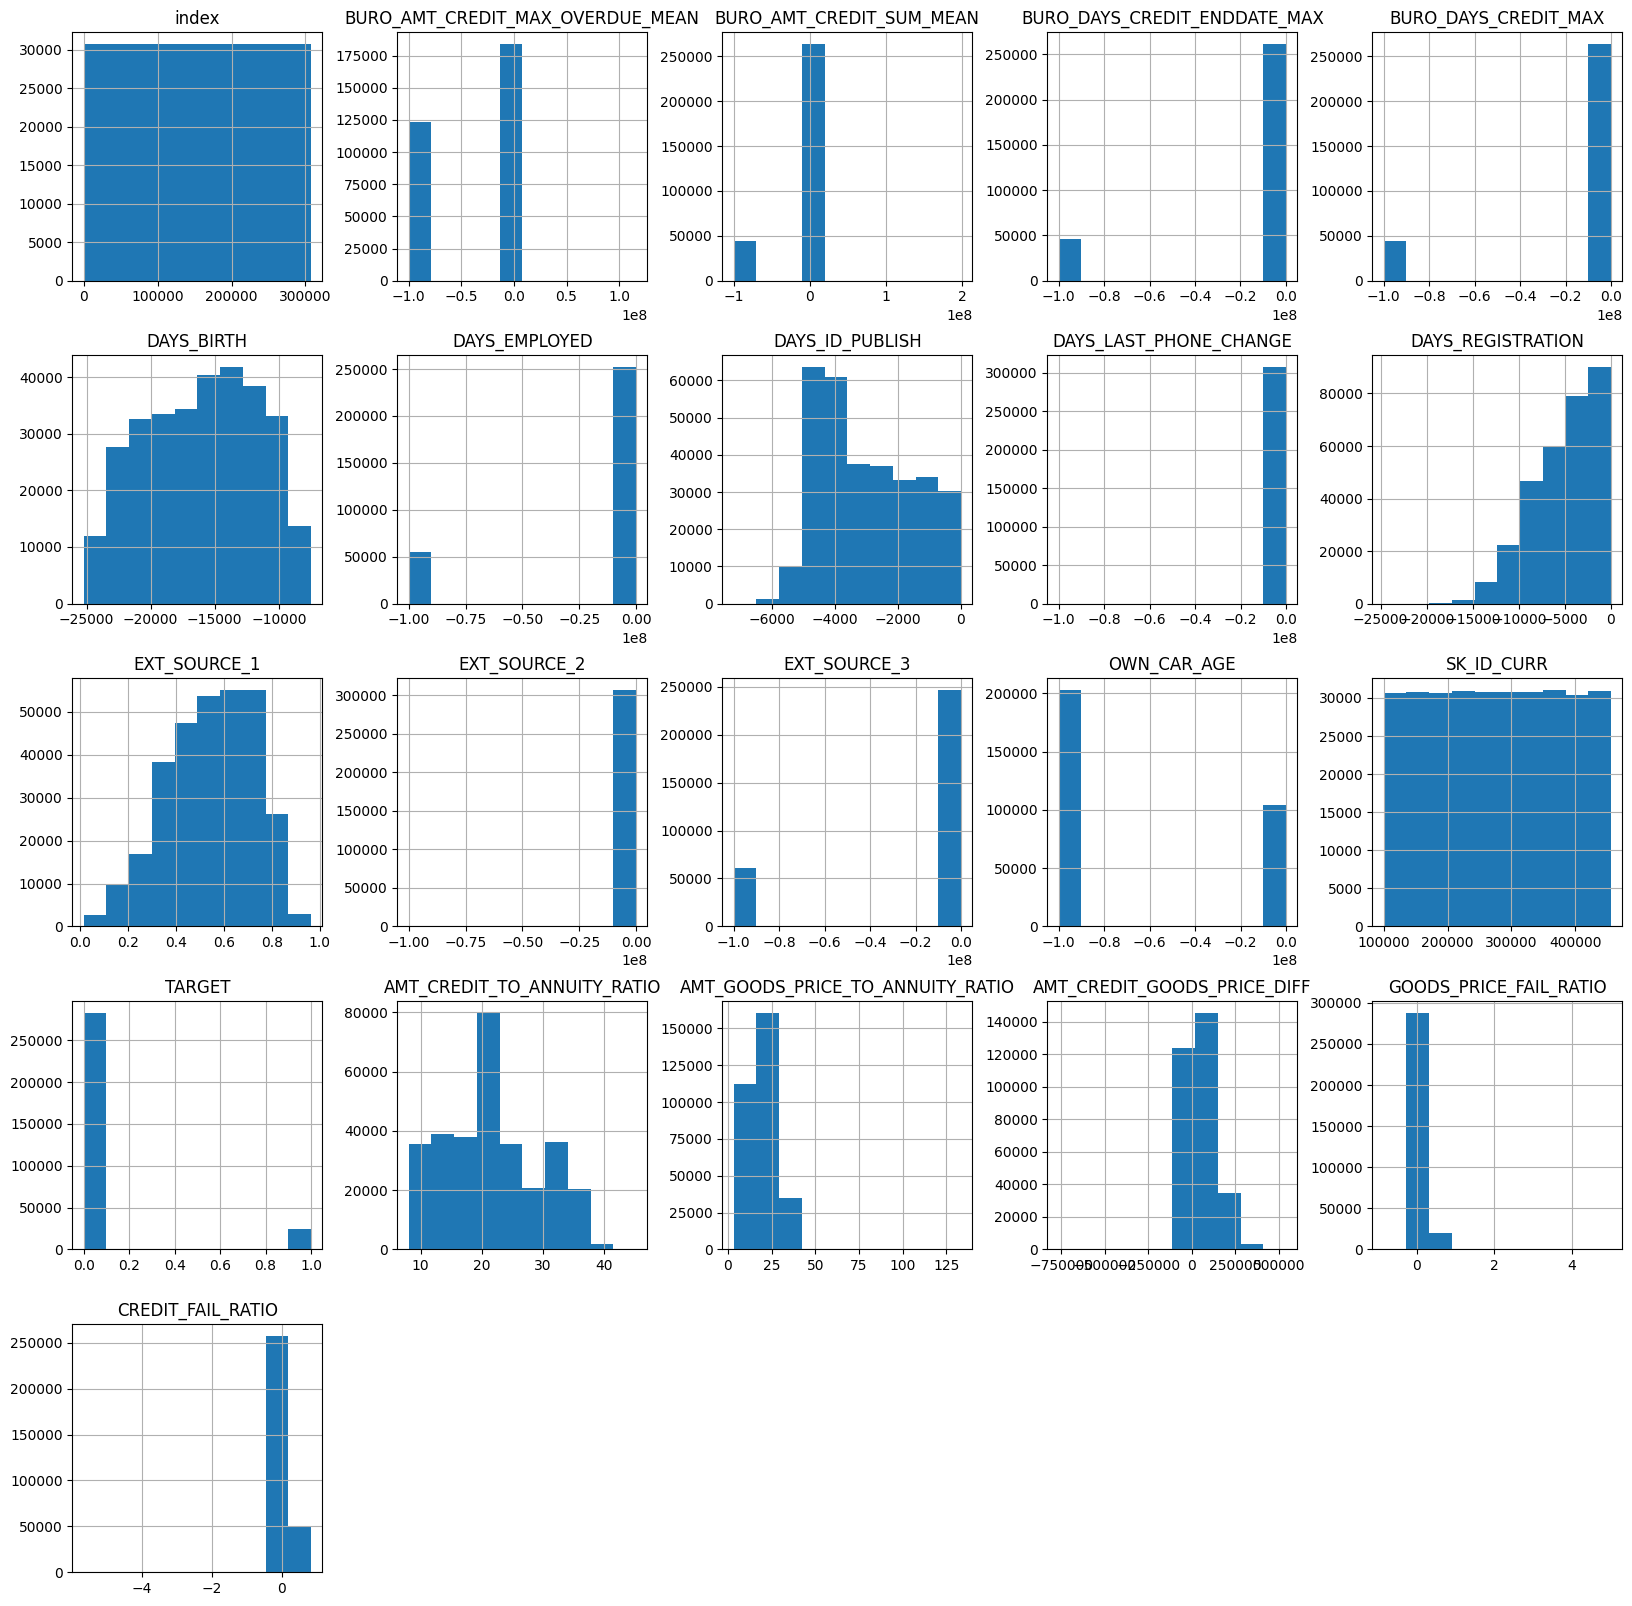

In [19]:
trimmed_df.hist(figsize=(20,20));

[Text(0.5, 0, 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN'),
 Text(1.5, 0, 'BURO_AMT_CREDIT_SUM_MEAN'),
 Text(2.5, 0, 'BURO_DAYS_CREDIT_ENDDATE_MAX'),
 Text(3.5, 0, 'BURO_DAYS_CREDIT_MAX'),
 Text(4.5, 0, 'DAYS_BIRTH'),
 Text(5.5, 0, 'DAYS_EMPLOYED'),
 Text(6.5, 0, 'DAYS_ID_PUBLISH'),
 Text(7.5, 0, 'DAYS_LAST_PHONE_CHANGE'),
 Text(8.5, 0, 'DAYS_REGISTRATION'),
 Text(9.5, 0, 'EXT_SOURCE_1'),
 Text(10.5, 0, 'EXT_SOURCE_2'),
 Text(11.5, 0, 'EXT_SOURCE_3'),
 Text(12.5, 0, 'OWN_CAR_AGE'),
 Text(13.5, 0, 'SK_ID_CURR'),
 Text(14.5, 0, 'TARGET')]

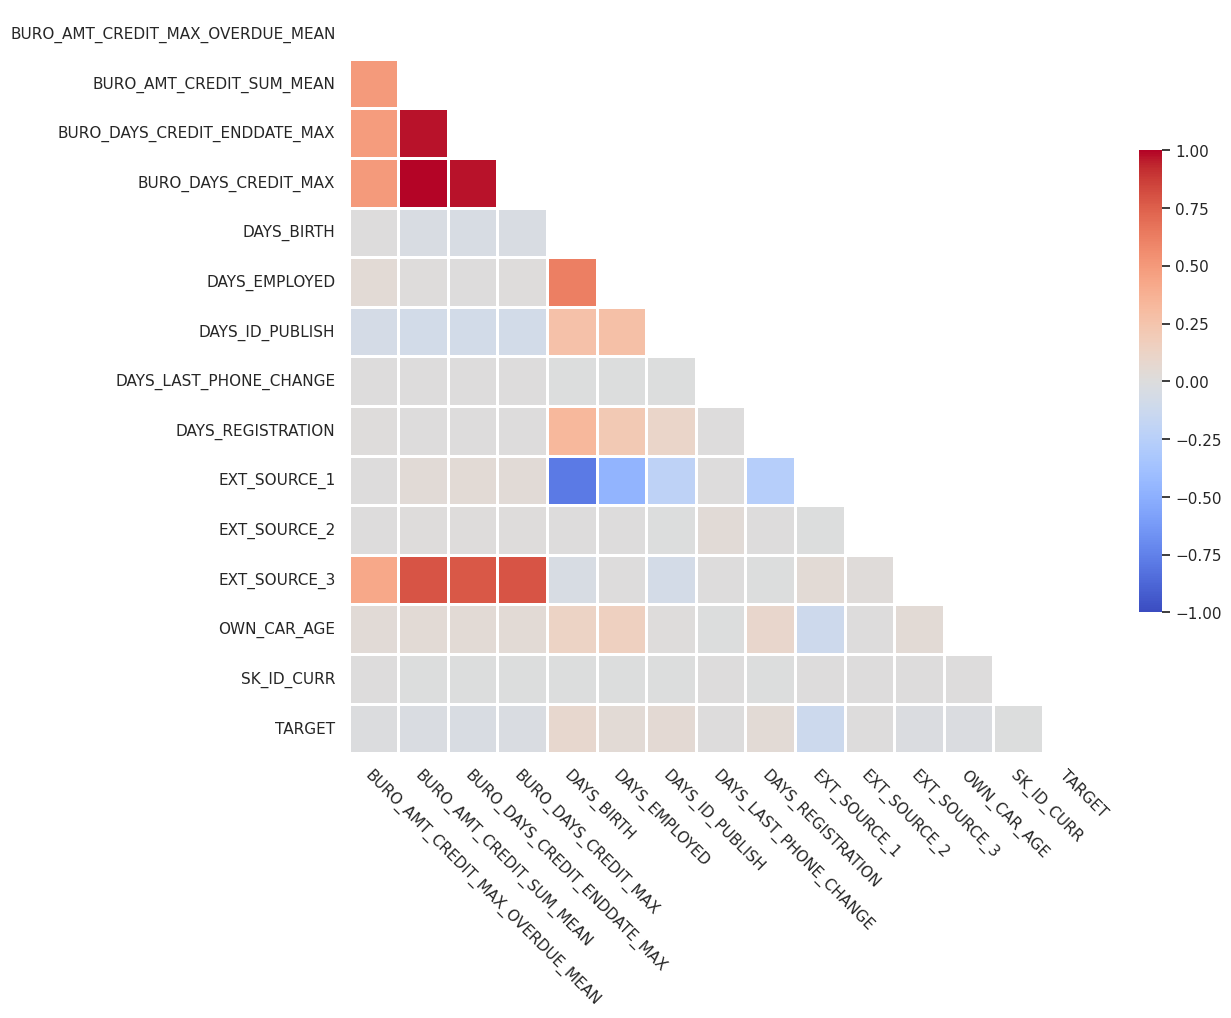

In [20]:
sns.set_theme(style="white")
r = trimmed_df[features_target].corr(method="pearson")
mask = np.triu(np.ones_like(r, dtype=bool))
plt.figure(figsize=(12,12))
heatmap = sns.heatmap(trimmed_df[features_target].corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='coolwarm', square=True, linewidths=1.0, cbar_kws={"shrink": .5})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=-45, rotation_mode='anchor', ha='left')

Je n'observe pas de corrélations aberrantes avec la sortie ('TARGET'), le data leaking est donc évité à ce niveau.

### Exportation du jeu de données total après prétraitement<a class="anchor" id="section_2_7"></a>

In [21]:
trimmed_df['TARGET'] = trimmed_df['TARGET'].astype('int')
trimmed_df.to_csv(OUTPUT_DATASETS_PATH + 'main_dataframe_pretreated.csv', header=True, index=False)

# Partie 3 : Modélisation<a class="anchor" id="partie3"></a>

### Initialisation de MLFlow<a class="anchor" id="section_3_1"></a>

In [22]:
mlflow.autolog()
mlflow.sklearn.autolog()
mlflow.lightgbm.autolog()
mlflow.xgboost.autolog()

2023/05/28 17:09:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/05/28 17:09:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/05/28 17:09:36 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2023/05/28 17:09:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/05/28 17:09:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


### Préparation des datasets d'entraînement / test / score<a class="anchor" id="section_3_2"></a>

In [23]:
X_train, X_test, y_train, y_test = prepare_datasets(trimmed_df)

### Modèle Baseline : Dummy Classifier<a class="anchor" id="section_3_3"></a>

In [24]:
mlflow.end_run()
with mlflow.start_run():
    dummy = DummyClassifier(strategy = "stratified")
    with timer("Entraînement du dummy model"):
        dummy.fit(X_train, y_train);
    y_dummy = dummy.predict(y_train)
    generate_stats(dummy, 'dummy', X_train, X_test, y_train, y_test)

Entraînement du dummy model - réalisé en 2s
Prédiction du dummy model - réalisé en 0s


### Régression Logistique<a class="anchor" id="section_3_4"></a>

2023/05/28 18:01:00 INFO mlflow.sklearn.utils: Logging the 5 best runs, 10 runs will be omitted.
2023/05/28 18:01:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bd6d02134e554e61aadea79e69bb38dd. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'n_jobs\' was already logged with value=\'-1\' for run ID=\'bd6d02134e554e61aadea79e69bb38dd\'. Attempted logging new value \'None\'.")]')]


Entraînement du logistic regression model - réalisé en 6s
Prédiction du logistic_regression model - réalisé en 0s


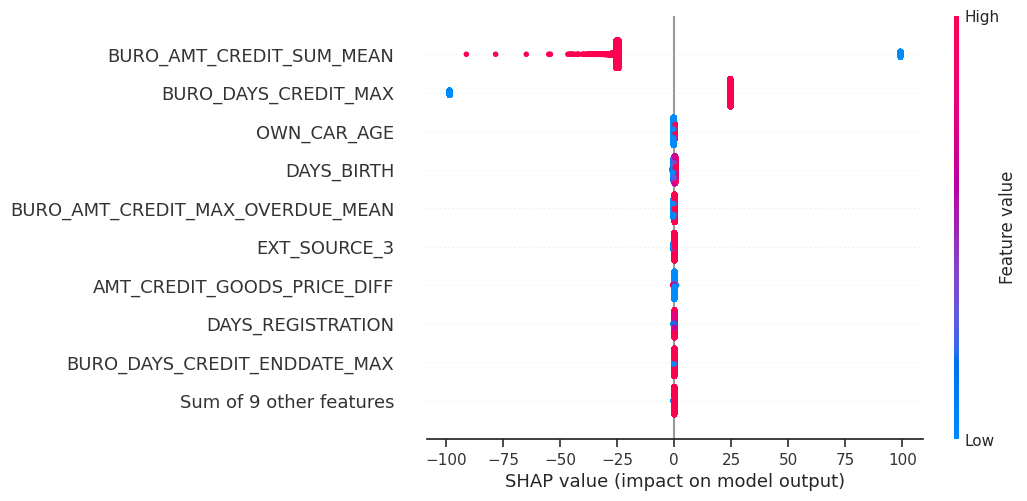

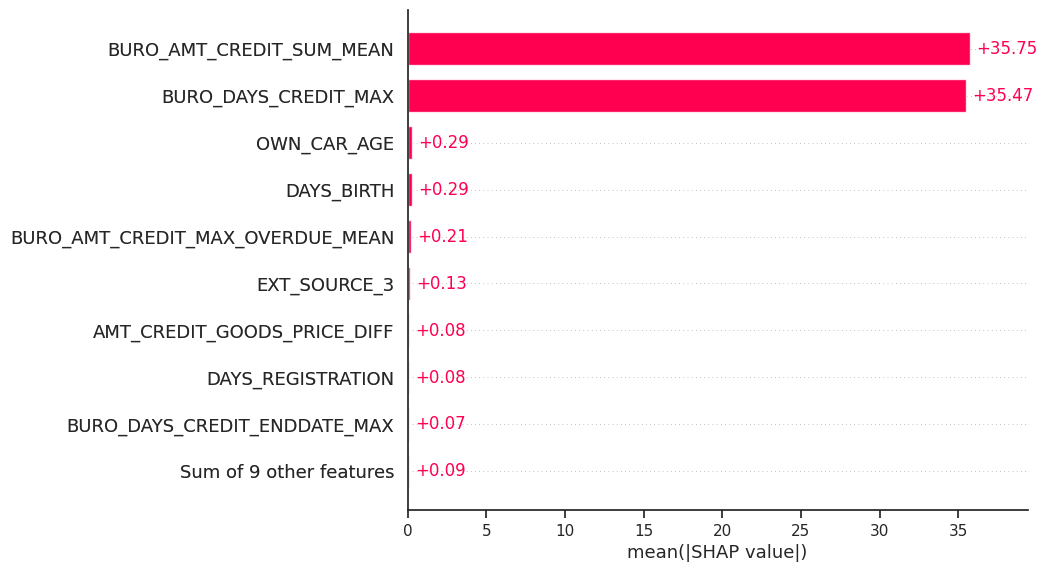

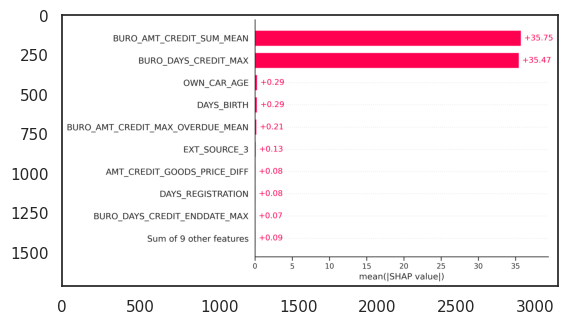

In [25]:
mlflow.end_run()
with mlflow.start_run():
    lr = LogisticRegression()
    
    lr_pipeline = imbpipeline([('smote', SMOTE(random_state=42)), ('lr', lr)])
    
    lr_grid = RandomizedSearchCV(estimator=lr_pipeline,
                                 param_distributions=lr_space,
                                 scoring=scoring,
                                 refit='fbeta_loss',
                                 n_iter=15,
                                 cv=cv,
                                 n_jobs=-1)
    lr_grid.fit(X_train, y_train)

    lr = LogisticRegression(C=lr_grid.best_params_['lr__C'],
                            penalty=lr_grid.best_params_['lr__penalty'],
                            solver=lr_grid.best_params_['lr__solver'],
                            class_weight=lr_grid.best_params_['lr__class_weight'])
    
    with timer("Entraînement du logistic regression model"):
        lr.fit(X_train, y_train);
    
    generate_stats(lr, 'logistic_regression', X_train, X_test, y_train, y_test)

### XGBoost<a class="anchor" id="section_3_5"></a>

2023/05/28 18:02:09 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
  ...`
2023/05/28 18:22:44 INFO mlflow.sklearn.utils: Logging the 5 best runs, 10 runs will be omitted.
2023/05/28 18:22:44 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('smote', SMOTE(random_state=42)), ('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=

Entraînement du XGBoost model - réalisé en 1s
Prédiction du xgboost model - réalisé en 0s


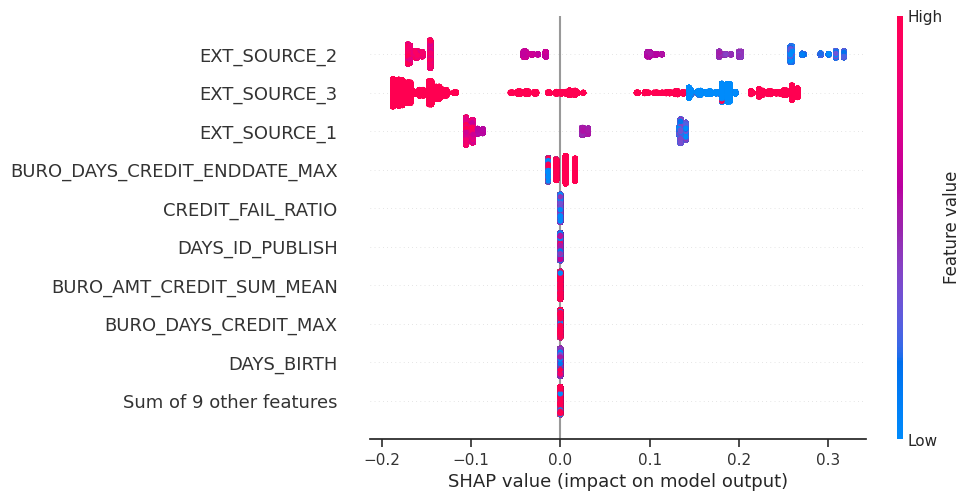

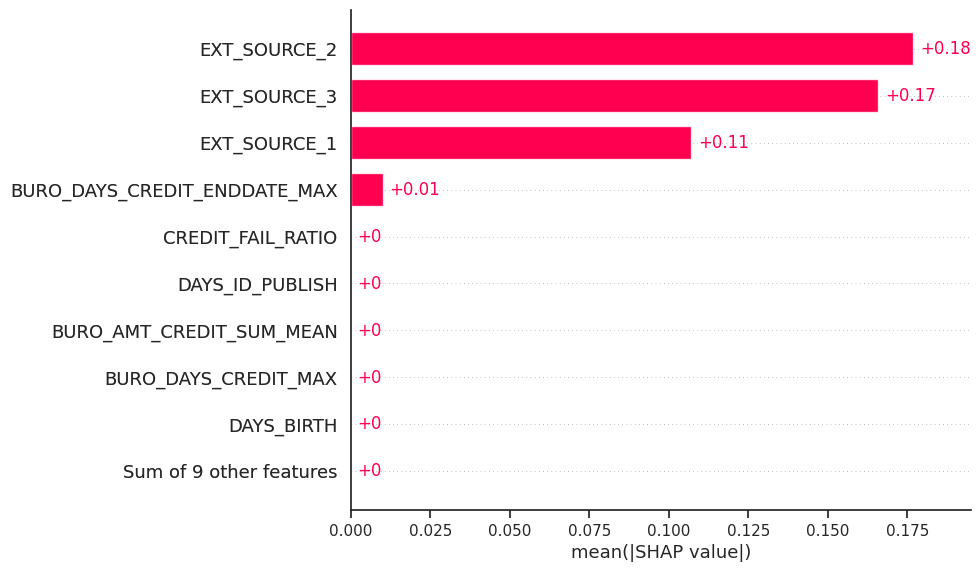

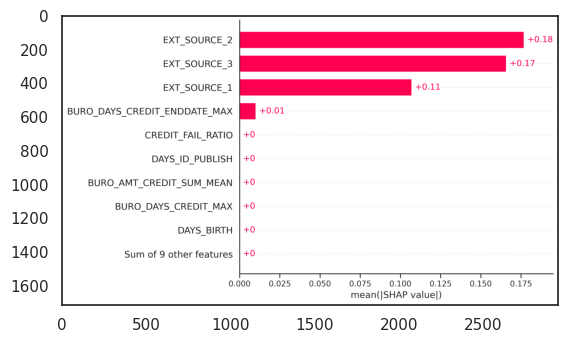

In [26]:
mlflow.end_run()
with mlflow.start_run():
    xgboost = XGBClassifier()
    
    xgboost_pipeline = imbpipeline([('smote', SMOTE(random_state=42)), ('xgb', xgboost)])
    
    xgboost_grid = RandomizedSearchCV(estimator=xgboost_pipeline,
                                      param_distributions=xgboost_space,
                                      scoring=scoring,
                                      refit='fbeta_loss',
                                      n_iter=15,
                                      cv=cv,
                                      n_jobs=-1)
    xgboost_grid.fit(X_train, y_train)

    xgboost = XGBClassifier(tree_method=xgboost_grid.best_params_['xgb__tree_method'],
                            subsample=xgboost_grid.best_params_['xgb__subsample'],
                            reg_lambda=xgboost_grid.best_params_['xgb__reg_lambda'],
                            reg_alpha=xgboost_grid.best_params_['xgb__reg_alpha'],
                            min_child_weight=xgboost_grid.best_params_['xgb__min_child_weight'],
                            max_depth=xgboost_grid.best_params_['xgb__max_depth'],
                            gamma=xgboost_grid.best_params_['xgb__gamma'],
                            colsample_bytree=xgboost_grid.best_params_['xgb__colsample_bytree'],
                            predictor='gpu_predictor')

    with timer("Entraînement du XGBoost model"):
        xgboost.fit(X_train, y_train);
    
    generate_stats(xgboost, 'xgboost', X_train, X_test, y_train, y_test)

### LightGBM<a class="anchor" id="section_3_6"></a>

In [27]:
mlflow.end_run()
with mlflow.start_run():
    lgbm = LGBMClassifier()
    
    lgbm_pipeline = imbpipeline([('smote', SMOTE(random_state=42)), ('lgbm', lgbm)])
    
    lgbm_grid = RandomizedSearchCV(estimator=lgbm_pipeline,
                                   param_distributions=lightgbm_space,
                                   scoring=scoring,
                                   refit='fbeta_loss',
                                   n_iter=15,
                                   cv=cv,
                                   n_jobs=-1)
    lgbm_grid.fit(X_train, y_train)

    lgbm = LGBMClassifier(n_estimators=lgbm_grid.best_params_['lgbm__n_estimators'],
                          learning_rate=lgbm_grid.best_params_['lgbm__learning_rate'],
                          num_leaves=lgbm_grid.best_params_['lgbm__num_leaves'],
                          colsample_bytree=lgbm_grid.best_params_['lgbm__colsample_bytree'],
                          subsample=lgbm_grid.best_params_['lgbm__subsample'],
                          max_depth=lgbm_grid.best_params_['lgbm__max_depth'],
                          reg_alpha=lgbm_grid.best_params_['lgbm__reg_alpha'],
                          reg_lambda=lgbm_grid.best_params_['lgbm__reg_lambda'],
                          min_split_gain=lgbm_grid.best_params_['lgbm__min_split_gain'],
                          bagging_fraction=lgbm_grid.best_params_['lgbm__bagging_fraction'],
                          bagging_freq=lgbm_grid.best_params_['lgbm__bagging_freq'],
                          feature_fraction=lgbm_grid.best_params_['lgbm__feature_fraction'],
                          min_data_in_leaf=lgbm_grid.best_params_['lgbm__min_data_in_leaf'])

    with timer("Entraînement du LightGBM model"):
        lgbm.fit(X_train, y_train);

    generate_stats(lgbm, 'lightgbm', X_train, X_test, y_train, y_test)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.95 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=18000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.95 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=18000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.95 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=20000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=18000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction 

2023/05/28 21:14:52 INFO mlflow.sklearn.utils: Logging the 5 best runs, 10 runs will be omitted.
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.95 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000


LightGBMError: CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1

In [28]:
lgbm = LGBMClassifier(n_estimators=lgbm_grid.best_params_['lgbm__n_estimators'],
                      learning_rate=lgbm_grid.best_params_['lgbm__learning_rate'],
                      num_leaves=lgbm_grid.best_params_['lgbm__num_leaves'],
                      colsample_bytree=lgbm_grid.best_params_['lgbm__colsample_bytree'],
                      subsample=lgbm_grid.best_params_['lgbm__subsample'],
                      max_depth=lgbm_grid.best_params_['lgbm__max_depth'],
                      reg_alpha=lgbm_grid.best_params_['lgbm__reg_alpha'],
                      reg_lambda=lgbm_grid.best_params_['lgbm__reg_lambda'],
                      min_split_gain=lgbm_grid.best_params_['lgbm__min_split_gain'],
                      bagging_fraction=lgbm_grid.best_params_['lgbm__bagging_fraction'],
                      bagging_freq=lgbm_grid.best_params_['lgbm__bagging_freq'],
                      feature_fraction=lgbm_grid.best_params_['lgbm__feature_fraction'],
                      min_data_in_leaf=lgbm_grid.best_params_['lgbm__min_data_in_leaf'])

with timer("Entraînement du LightGBM model"):
    lgbm.fit(X_train, y_train);

generate_stats(lgbm, 'lightgbm', X_train, X_test, y_train, y_test)

2023/05/28 21:15:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f708b047df0b48b094050a83f3ae4c79', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=18000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=18000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction i

### Évaluation de la courbe ROC (AUC)<a class="anchor" id="section_3_7"></a>

<Figure size 640x480 with 0 Axes>

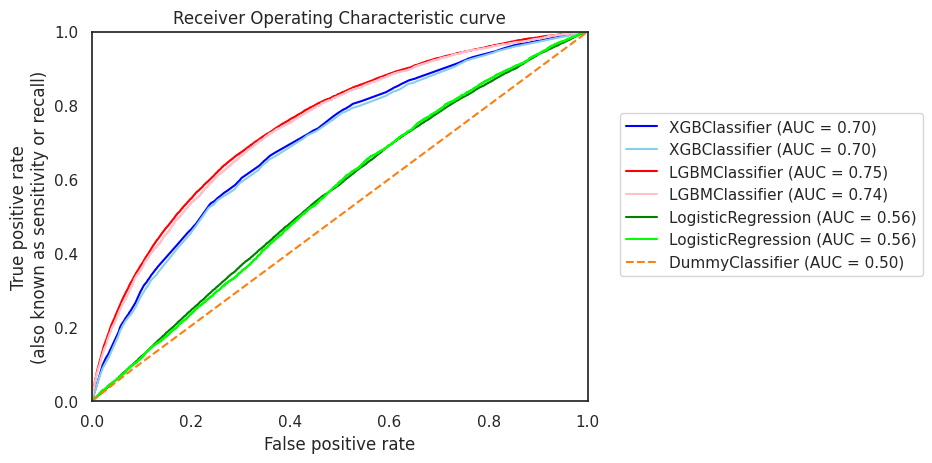

In [29]:
plt.clf()
disp = RocCurveDisplay.from_estimator(
    xgboost, X_train, y_train, color='blue')

disp = RocCurveDisplay.from_estimator(
    xgboost, X_test, y_test,
    color='skyblue', ax=disp.ax_)

disp = RocCurveDisplay.from_estimator(
    lgbm, X_train, y_train,
    color='red', ax=disp.ax_)

disp = RocCurveDisplay.from_estimator(
    lgbm, X_test, y_test,
    color='pink', ax=disp.ax_)

disp = RocCurveDisplay.from_estimator(
    lr, X_train, y_train,
    color='green', ax=disp.ax_)

disp = RocCurveDisplay.from_estimator(
    lr, X_test, y_test,
    color='lime', ax=disp.ax_)

disp = RocCurveDisplay.from_estimator(
    dummy, X_test, y_test,
    color="tab:orange", linestyle="--", ax=disp.ax_)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate\n(also known as sensitivity or recall)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Receiver Operating Characteristic curve")
plt.show()

Les évaluations donnent plusieurs pistes. Le LightGBM est globalement le modèle le plus performant. Cependant, sa bonne tenue est plus difficile à conserver (remarque empirique). De ce fait, XGBoost sera conservé comme modèle final. Ses performances sont correctes, tout en maintenant une excellente constance au fil des différents tests menés. Il propose en outre un bon support des logiciels tiers (exemples : Plotly et SHAP), ce qui permet d'envisager des représentations graphiques pertinentes et impactantes.

### Fine Tuning du modèle sélectionné<a class="anchor" id="section_3_8"></a>

In [30]:
# Définition de l'espace de recherche du XGBoost pour la BayesSearchCV
ftxgboost_space = dict()
ftxgboost_space['ftxgb__n_estimators'] = np.linspace(100, 3000, 1000, dtype=int).tolist()
ftxgboost_space['ftxgb__gamma'] = [1, 2]
ftxgboost_space['ftxgb__colsample_bytree'] = np.linspace(0.8, 1.0, num=10).tolist()
ftxgboost_space['ftxgb__subsample'] = [1]
ftxgboost_space['ftxgb__max_depth'] = [2, 3]
ftxgboost_space['ftxgb__reg_alpha'] = [0.02, 0.03, 0.04]
ftxgboost_space['ftxgb__reg_lambda'] = [0.05, 0.06, 0.07]
ftxgboost_space['ftxgb__min_child_weight'] = np.linspace(800, 1200, 100, dtype=int).tolist()
ftxgboost_space['ftxgb__tree_method'] = ['gpu_hist']

2023/05/28 21:43:46 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 21:43:46 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 21:43:46 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 21:43:47 WARNING mlflow.utils.requirements_utils: Found scikit-optimize version (0.9.0+unofficial) contains a local version label (+unofficial). MLflow logged a pip requirement for this package as 'scikit-optimize==0.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/28 21:46:17 WARNING mlflow.sklearn.utils: Fail

2023/05/28 21:51:51 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 21:51:51 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 21:51:51 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 21:51:52 WARNING mlflow.utils.requirements_utils: Found scikit-optimize version (0.9.0+unofficial) contains a local version label (+unofficial). MLflow logged a pip requirement for this package as 'scikit-optimize==0.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/28 21:53:35 WARNING mlflow.sklearn.utils: Fail

2023/05/28 21:58:54 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 21:58:54 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 21:58:54 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 21:58:55 WARNING mlflow.utils.requirements_utils: Found scikit-optimize version (0.9.0+unofficial) contains a local version label (+unofficial). MLflow logged a pip requirement for this package as 'scikit-optimize==0.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/28 22:02:57 WARNING mlflow.sklearn.utils: Fail

2023/05/28 22:09:43 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:09:43 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:09:43 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:09:44 WARNING mlflow.utils.requirements_utils: Found scikit-optimize version (0.9.0+unofficial) contains a local version label (+unofficial). MLflow logged a pip requirement for this package as 'scikit-optimize==0.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/28 22:12:12 WARNING mlflow.sklearn.utils: Fail

2023/05/28 22:16:33 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:16:33 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:16:33 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:16:34 WARNING mlflow.utils.requirements_utils: Found scikit-optimize version (0.9.0+unofficial) contains a local version label (+unofficial). MLflow logged a pip requirement for this package as 'scikit-optimize==0.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/28 22:17:57 WARNING mlflow.sklearn.utils: Fail

2023/05/28 22:20:57 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:20:57 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:20:57 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:20:58 WARNING mlflow.utils.requirements_utils: Found scikit-optimize version (0.9.0+unofficial) contains a local version label (+unofficial). MLflow logged a pip requirement for this package as 'scikit-optimize==0.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/28 22:22:42 WARNING mlflow.sklearn.utils: Fail

2023/05/28 22:30:33 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:30:33 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:30:33 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2023/05/28 22:30:34 WARNING mlflow.utils.requirements_utils: Found scikit-optimize version (0.9.0+unofficial) contains a local version label (+unofficial). MLflow logged a pip requirement for this package as 'scikit-optimize==0.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/05/28 22:32:01 WARNING mlflow.sklearn.utils: Fail

2023/05/28 22:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 6352986c44714f79b6d360e1e5a84ae6. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'predictor\' was already logged with value=\'None\' for run ID=\'6352986c44714f79b6d360e1e5a84ae6\'. Attempted logging new value \'gpu_predictor\'.")]')]


Entraînement du Fine Tuned XGBoost model - réalisé en 2s
Prédiction du fine_tuned_XGBoost model - réalisé en 0s


 98%|===================| 54317/55352 [00:22<00:00]        

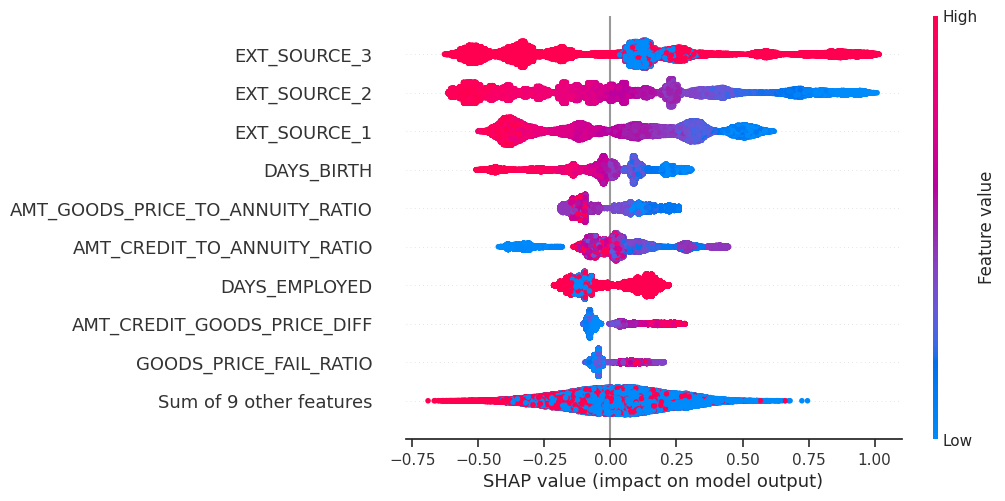

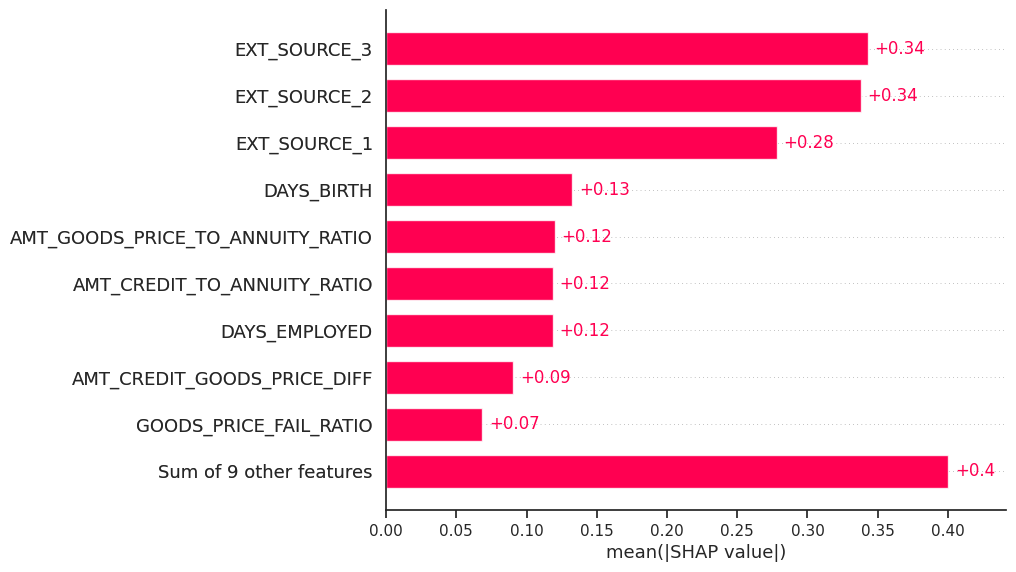

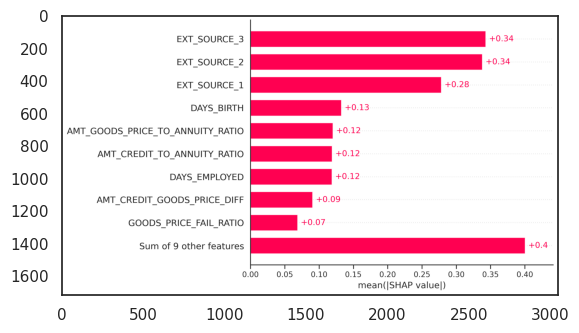

In [31]:
mlflow.end_run()
with mlflow.start_run():
    ftxgboost = XGBClassifier()

    ftxgboost_pipeline = imbpipeline([('smote', SMOTE(random_state=42)), ('ftxgb', ftxgboost)])

    ftxgboost_grid = BayesSearchCV(estimator=ftxgboost_pipeline,
                                     search_spaces=ftxgboost_space,
                                     n_jobs=-1,
                                     cv=cv,
                                     scoring=scoring,
                                     refit='fbeta_loss',
                                     n_iter=30)
    ftxgboost_grid.fit(X_train, y_train);
    
    ftxgboost = XGBClassifier(tree_method=ftxgboost_grid.best_params_['ftxgb__tree_method'],
                              subsample=ftxgboost_grid.best_params_['ftxgb__subsample'],
                              reg_lambda=ftxgboost_grid.best_params_['ftxgb__reg_lambda'],
                              reg_alpha=ftxgboost_grid.best_params_['ftxgb__reg_alpha'],
                              min_child_weight=ftxgboost_grid.best_params_['ftxgb__min_child_weight'],
                              max_depth=ftxgboost_grid.best_params_['ftxgb__max_depth'],
                              gamma=ftxgboost_grid.best_params_['ftxgb__gamma'],
                              colsample_bytree=ftxgboost_grid.best_params_['ftxgb__colsample_bytree'],
                              predictor='gpu_predictor')
    
    with timer("Entraînement du Fine Tuned XGBoost model"):
        ftxgboost.fit(X_train, y_train);
    
    generate_stats(ftxgboost, 'fine_tuned_XGBoost', X_train, X_test, y_train, y_test)

### Évaluation de la courbe ROC (AUC) du modèle Fine Tuned<a class="anchor" id="section_3_9"></a>

<Figure size 640x480 with 0 Axes>

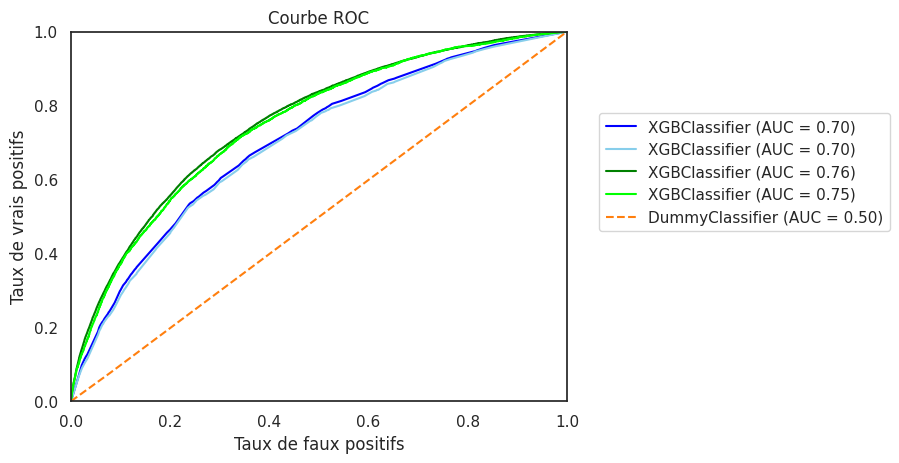

In [32]:
plt.clf()

disp = RocCurveDisplay.from_estimator(
    xgboost, X_train, y_train, color='blue')

disp = RocCurveDisplay.from_estimator(
    xgboost, X_test, y_test,
    color='skyblue', ax=disp.ax_)

disp = RocCurveDisplay.from_estimator(
    ftxgboost, X_train, y_train,
    color='green', ax=disp.ax_)

disp = RocCurveDisplay.from_estimator(
    ftxgboost, X_test, y_test,
    color='lime', ax=disp.ax_)

disp = RocCurveDisplay.from_estimator(
    dummy, X_test, y_test,
    color="tab:orange", linestyle="--", ax=disp.ax_)

plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Courbe ROC")
plt.show()

### Déclaration du modèle final<a class="anchor" id="section_3_10"></a>

In [33]:
final_model = XGBClassifier(tree_method=ftxgboost_grid.best_params_['ftxgb__tree_method'],
                          subsample=ftxgboost_grid.best_params_['ftxgb__subsample'],
                          reg_lambda=ftxgboost_grid.best_params_['ftxgb__reg_lambda'],
                          reg_alpha=ftxgboost_grid.best_params_['ftxgb__reg_alpha'],
                          min_child_weight=ftxgboost_grid.best_params_['ftxgb__min_child_weight'],
                          max_depth=ftxgboost_grid.best_params_['ftxgb__max_depth'],
                          gamma=ftxgboost_grid.best_params_['ftxgb__gamma'],
                          colsample_bytree=ftxgboost_grid.best_params_['ftxgb__colsample_bytree'])

with timer("Entraînement du Fine Tuned XGBoost model"):
    final_model.fit(X_train, y_train);

2023/05/28 22:40:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'add1a54e234f440ea669c8c25c3cb026', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


Entraînement du Fine Tuned XGBoost model - réalisé en 2s


### Création des SHAP Explainer / Values pour l'interprétabilité locale et globale<a class="anchor" id="section_3_11"></a>

In [34]:
shap_explainer = shap.TreeExplainer(final_model, X_test, algorithm = 'auto', n_jobs = -1)
shap_values = shap_explainer(X_test)

 98%|===================| 54326/55352 [00:22<00:00]        

### Sérialisation des modèles et des SHAP Explainer / Values<a class="anchor" id="section_3_12"></a>

In [35]:
pickle.dump(dummy, open(PICKLED_MODELS_PATH + 'dummy.pkl', 'wb'))
pickle.dump(lr, open(PICKLED_MODELS_PATH + 'lr.pkl', 'wb'))
pickle.dump(xgboost, open(PICKLED_MODELS_PATH + 'xgboost.pkl', 'wb'))
pickle.dump(lgbm, open(PICKLED_MODELS_PATH + 'lightgbm.pkl', 'wb'))
pickle.dump(ftxgboost, open(PICKLED_MODELS_PATH + 'final_model.pkl', 'wb'))
pickle.dump(shap_explainer, open(PICKLED_MODELS_PATH + 'final_model_shap_explainer.pkl', 'wb'))
pickle.dump(shap_values, open(PICKLED_MODELS_PATH + 'final_model_shap_values.pkl', 'wb'))

### Chargement des datasets sauvegardés précédemment et définition des datasets évalués<a class="anchor" id="section_3_13"></a>

In [36]:
train_df = pd.read_csv(OUTPUT_DATASETS_PATH + 'train_data.csv')
test_df = pd.read_csv(OUTPUT_DATASETS_PATH + 'test_data.csv')
score_df = pd.read_csv(OUTPUT_DATASETS_PATH + 'score_data.csv')
newclients_df = pd.read_csv(OUTPUT_DATASETS_PATH + 'newclients_data.csv')

dd_features = [f for f in train_df.columns if f not in ['level_0', 'AMT_CREDIT_TO_ANNUITY_RATIO', 'AMT_GOODS_PRICE_TO_ANNUITY_RATIO', 'AMT_CREDIT_GOODS_PRICE_DIFF', 'GOODS_PRICE_FAIL_RATIO', 'CREDIT_FAIL_RATIO', 'TARGET', 'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

train_df = train_df[dd_features]
test_df = test_df[dd_features]
score_df = score_df[dd_features]
newclients_df = newclients_df[dd_features]

# Analyse du Data Drift (evidently)<a class="anchor" id="partie4"></a>

### Train vs Test<a class="anchor" id="section_4_1"></a>

In [37]:
report = Report(metrics=[DataDriftPreset(),])

tests = TestSuite(tests=[
    TestNumberOfColumnsWithMissingValues(),
    TestNumberOfRowsWithMissingValues(),
    TestNumberOfConstantColumns(),
    TestNumberOfDuplicatedRows(),
    TestNumberOfDuplicatedColumns(),
    TestColumnsType(),
    TestNumberOfDriftedColumns(),
])

report.run(reference_data=train_df, current_data=test_df)
report.save_html(EVIDENTLY_PATH + 'report_train_test.html')

tests.run(reference_data=train_df, current_data=test_df)
tests.save_html(EVIDENTLY_PATH + 'stability_train_test.html')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=20000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=20000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.75 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22000
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.75 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction 

### Train vs Score<a class="anchor" id="section_4_2"></a>

In [38]:
report = Report(metrics=[DataDriftPreset(),])

tests = TestSuite(tests=[
    TestNumberOfColumnsWithMissingValues(),
    TestNumberOfRowsWithMissingValues(),
    TestNumberOfConstantColumns(),
    TestNumberOfDuplicatedRows(),
    TestNumberOfDuplicatedColumns(),
    TestColumnsType(),
    TestNumberOfDriftedColumns(),
])

report.run(reference_data=train_df, current_data=score_df)
report.save_html(EVIDENTLY_PATH + 'report_train_score.html')

tests.run(reference_data=train_df, current_data=score_df)
tests.save_html(EVIDENTLY_PATH + 'stability_train_score.html')

### Train vs App<a class="anchor" id="section_4_3"></a>

In [39]:
report = Report(metrics=[DataDriftPreset(),])

tests = TestSuite(tests=[
    TestNumberOfColumnsWithMissingValues(),
    TestNumberOfRowsWithMissingValues(),
    TestNumberOfConstantColumns(),
    TestNumberOfDuplicatedRows(),
    TestNumberOfDuplicatedColumns(),
    TestColumnsType(),
    TestNumberOfDriftedColumns(),
])

report.run(reference_data=train_df, current_data=newclients_df)
report.save_html(EVIDENTLY_PATH + 'report_train_app.html')

tests.run(reference_data=train_df, current_data=newclients_df)
tests.save_html(EVIDENTLY_PATH + 'stability_train_app.html')